# Prepare ENV/Load libraries

In [1]:
# !rm -rf tmp && git clone https://github.com/chuan-khuna/my-python-utils.git tmp && cp -R tmp/utils ./ && cp -R tmp/fonts ./ && rm -rf tmp

In [2]:
!python3 --version

Python 3.8.16


In [3]:
!pip install matplotlib seaborn -Uq
!pip install pythainlp -q
!pip install keras-tuner -q
!pip install pyYAML -q
!pip install tensorflow-io[tensorflow] tf2onnx onnxruntime -Uq

In [4]:
%load_ext tensorboard

## Mount Google Drive

In [5]:
import os
from google.colab import drive

drive.mount('/content/gdrive')
google_drive_path = "/content/gdrive/MyDrive/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
# change directory to the project path

project_path = os.path.join(google_drive_path, "Colab Notebooks/SER ME/")
os.chdir(project_path)
os.listdir("./")

['utils',
 'fonts',
 'meta_data',
 'dataset',
 '.git',
 '.env',
 'config.yml',
 'libs',
 'README.md',
 'models',
 'Notebook Template.ipynb',
 '.gitignore',
 'logs',
 'Preprocess Json to CSV.ipynb',
 'Untitled0.ipynb',
 'HyperParams Tuning Train LSTM.ipynb']

# Import Libraries

In [7]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
from matplotlib import patheffects
import seaborn as sns

import json
import yaml
import re
from tqdm.notebook import trange, tqdm

import datetime

In [8]:
import tensorflow as tf
import tensorflow_datasets as tfds
import keras_tuner

seed_ = 20200218
tf.random.set_seed(seed_)
np.random.seed(seed_)

from sklearn.metrics import confusion_matrix, classification_report

In [9]:
import tf2onnx
import onnx
import onnxruntime as rt

In [10]:
import librosa
from librosa.display import specshow
import tensorflow_io as tfio
from IPython.display import Audio

In [11]:
from utils.vis_utils import *
from libs.audio_preprocessing import AudioPreprocessor

font_dir = [f"{google_drive_path}/code_assets/fonts/"]
mpl_import_fonts(font_dir)

In [12]:
def get_timestamp():
    timestamp = datetime.datetime.strftime(datetime.datetime.now(), "%Y%m%d-%H%M")
    return timestamp

get_timestamp()

'20221212-0726'

## Ensure that matplotlib can use subplot mosaic

In [13]:
def check_version(version_str, major, minor):
    print(version_str)
    version = [int(i) for i in version_str.split('.')]
    assert version[0] >= major and version[1] >= minor

check_version(matplotlib.__version__, 3, 6)
check_version(sns.__version__, 0, 12)

del check_version

matplotlib.__version__, sns.__version__, tf.__version__

3.6.2
0.12.1


('3.6.2', '0.12.1', '2.11.0')

## View hardware spec

In [14]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [15]:
tf.config.list_physical_devices('GPU')

for device in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(device, True)

## Config Tensorflow precision

In [16]:
# use mixed precision

policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


Compute dtype: float16
Variable dtype: float32


# Load Dataframe

In [17]:
df = pd.read_csv("./meta_data/dataset.csv")

In [18]:
# drop emotion label that tagged as None
df = df[df['majority_emo'] != 'None']
df = df[df['majority_emo'] != 'other']
df = df[df['agreement'] >= 0.75]

# shuffle
df = df.sample(frac=1)

In [19]:
label_col = "majority_emo"
df = df.join(pd.get_dummies(df[label_col]))

In [20]:
df

,path,file,assigned_emo,majority_emo,agreement,Angry,Frustrated,Happy,Neutral,Sad
32484,./dataset/studio21-30/studio021/con/s021_con_a...,s021_con_actor077_impro10_24.flac,Angry,Neutral,0.750000,0,0,0,1,0
19032,./dataset/zoom1-10/zoom010/mic/z010_mic_actor0...,z010_mic_actor055_script1_1_1a.flac,Neutral,Neutral,0.800000,0,0,0,1,0
736,./dataset/zoom11-20/zoom013/mic/z013_mic_actor...,z013_mic_actor062_impro2_5.flac,Happy,Happy,0.900000,0,0,1,0,0
1755,./dataset/zoom11-20/zoom016/mic/z016_mic_actor...,z016_mic_actor068_script3_1_2a.flac,Angry,Angry,0.900000,1,0,0,0,0
25846,./dataset/studio31-40/studio033/con/s033_con_a...,s033_con_actor106_script2_1_2b.flac,Angry,Frustrated,0.800000,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
15646,./dataset/studio11-20/studio017/con/s017_con_a...,s017_con_actor034_impro5_11.flac,Sad,Sad,0.916667,0,0,0,0,1
111,./dataset/zoom11-20/zoom011/mic/z011_mic_actor...,z011_mic_actor058_impro3_14.flac,Neutral,Neutral,0.800000,0,0,0,1,0
17386,./dataset/zoom1-10/zoom004/mic/z004_mic_actor0...,z004_mic_actor043_impro4_25.flac,Angry,Frustrated,1.000000,0,1,0,0,0
456,./dataset/zoom11-20/zoom012/mic/z012_mic_actor...,z012_mic_actor060_impro2_2.flac,Happy,Happy,0.750000,0,0,1,0,0


In [21]:
classes = pd.get_dummies(df[label_col]).columns
num_classes = len(classes)
list(classes)

['Angry', 'Frustrated', 'Happy', 'Neutral', 'Sad']

In [22]:
class_weight = {}
for i, c in enumerate(list(classes)):
    class_size = (df[label_col] == c).sum()
    class_weight[i] = np.round(1/class_size * len(df)/2.0, 3)

class_weight

{0: 3.206755753526355,
 1: 2.308658471405665,
 2: 2.0826904532304726,
 3: 1.831072488342518,
 4: 4.371963562753036}

In [ ]:
# No class_weight

# class_weight = None

In [23]:
def show_tensor(tensor, take_n=3):
    return list(tensor.take(take_n).as_numpy_iterator())

In [24]:
def plot_spectrogram(tensor):
    fig = plt.figure(figsize=(9, 3), dpi=100)
    sns.heatmap(tensor.numpy().squeeze())
    plt.show()

# Config Proprocessing process

In [25]:
img_w, img_h = n_timesteps, n_features = 512, 64

prep = AudioPreprocessor()

prep.img_h = img_h
prep.img_w = img_w
prep.img_ch = 1
prep.nfft = 512
prep.window_length = 512
prep.mel_sr = 44100
prep.n_mels = 128

In [26]:
setting = prep.__dict__
setting['classes'] = list(classes)
setting['class_weight'] = class_weight
setting

{'nfft': 512,
 'window_length': 512,
 'stride': 256,
 'mel_sr': 44100,
 'n_mels': 128,
 'max_db': 80,
 'img_h': 64,
 'img_w': 512,
 'img_ch': 1,
 'classes': ['Angry', 'Frustrated', 'Happy', 'Neutral', 'Sad']}

# Load Tensorflow dataset from df

In [27]:
def load_file_as_spectrogram_map(x, y):
    tensor = prep.from_file(x)
    tensor = prep._normalize(tensor)
    tensor = prep.preprocess(tensor)
    return tensor, y

def preprocess_spectrogram_map(x, y):
    x = tf.transpose(x, perm=[1, 0, 2])
    x = tf.image.resize(x, size=(n_timesteps, n_features))
    return tf.squeeze(x), y

In [28]:
ds = tf.data.Dataset.from_tensor_slices((df['path'], df[list(classes)]))

ds = ds.map(load_file_as_spectrogram_map)
ds = ds.map(preprocess_spectrogram_map)

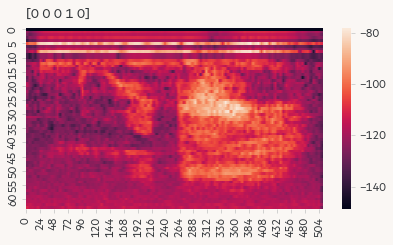

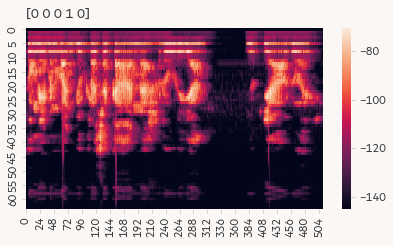

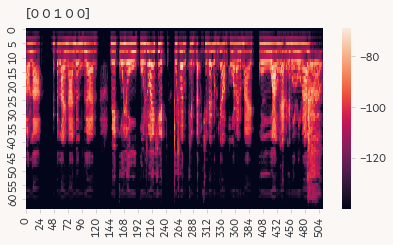

In [29]:
for x, y in ds.take(3):
    fig = plt.figure(figsize=(6, 3), dpi=80)
    sns.heatmap(x.numpy().T)
    plt.title(str(y.numpy()))
    plt.show()

## Split dataset

In [30]:
TRAIN_SIZE, VAL_SIZE = 0.7, 0.2

TRAIN_SIZE, VAL_SIZE = int(TRAIN_SIZE*len(df)), int(VAL_SIZE*len(df))
TEST_SIZE = len(df) - (TRAIN_SIZE + VAL_SIZE)
TRAIN_SIZE, VAL_SIZE, TEST_SIZE

(6047, 1727, 865)

In [31]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 32
SHUFFLE_SIZE = 500

# split train-validation
train_ds = ds.shuffle(SHUFFLE_SIZE, seed=seed_, reshuffle_each_iteration=False).take(TRAIN_SIZE)
val_ds = ds.shuffle(SHUFFLE_SIZE, seed=seed_,
                    reshuffle_each_iteration=False).skip(TRAIN_SIZE).take(VAL_SIZE)
test_ds = ds.shuffle(SHUFFLE_SIZE, seed=seed_,
                     reshuffle_each_iteration=False).skip(TRAIN_SIZE + VAL_SIZE).take(TEST_SIZE)

# prepare to train
train_ds = train_ds.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)

# Model

In [32]:
from tensorflow.keras.layers import *

## Hypermodel

Search for best batch size

```py
def fit(self, hp, model, *args, **kwargs):

    AUTOTUNE = tf.data.AUTOTUNE
    batch_size = hp.Choice('batch_size', [64, 32, 24, 16, 8])

    data = args[0]
    train_data = data.batch(batch_size).cache().prefetch(AUTOTUNE)

    if 'validation_data' in kwargs.keys():
        val_data = kwargs['validation_data'].batch(batch_size).cache().prefetch(AUTOTUNE)
        kwargs['validation_data'] = val_data
        hist = model.fit(train_data, **kwargs)
    else:
        hist = model.fit(train_data, **kwargs)

    return hist
```

deprecated LSTM hyperparams
```py
lstm_dropout = hp.Choice(f'lstm_{i}_dropout', [0.1, 0.2, 0.25, 0.3, 0.4, 0.5])
rec_act = hp.Choice(f"lstm_{i}_reccurent_act", ['tanh', 'relu', 'leaky_relu', 'gelu'])
act = hp.Choice(f"lstm_{i}_act", ['tanh', 'sigmoid'])

dropout=lstm_dropout
recurrent_dropout=lstm_dropout,
recurrent_activation=rec_act,
activation=act
```

In [33]:
class MyHyperModel(keras_tuner.HyperModel):

    def build(self, hp):
        model = tf.keras.Sequential()

        model.add(InputLayer(input_shape=(n_timesteps, n_features)))

        # Conv1D
        for i in range(hp.Int("num_conv1d_layers", 1, 4)):
            filter_size = hp.Choice(f'conv1d_{i}_filters', [256, 128, 96, 64, 32, 24, 16, 8])
            kernel_size = hp.Choice(f'conv1d_{i}_kernel', [3, 4, 5])
            model.add(Conv1D(filter_size, kernel_size))
            model.add(BatchNormalization())
            model.add(MaxPool1D())

        num_lstm_layer = hp.Int("num_rnn_layers", 1, 3)
        for i in range(num_lstm_layer):
            bidir = hp.Choice(f'lstm_{i}_bidir', [True, False])
            lstm_units = hp.Choice(f'lstm_{i}_units', [256, 128, 96, 64, 48, 32, 24, 16, 8])

            # handling last LSTM layer
            if i == (num_lstm_layer - 1):
                return_seq = False
            else:
                return_seq = True

            if bidir:
                model.add(Bidirectional(LSTM(lstm_units, return_sequences=return_seq)))
            else:
                model.add(LSTM(lstm_units, return_sequences=return_seq))

        for i in range(hp.Int("num_dense_layers", 1, 4)):
            act = hp.Choice(f"dense_{i}_act", ['tanh', 'sigmoid', 'linear', 'relu', 'gelu'])
            dense_unit_sizes = hp.Choice(f'dense_{i}_units', [128, 96, 64, 32, 24, 16, 8])
            model.add(Dense(dense_unit_sizes))
            if act != 'linear':
                model.add(Activation(act))
            dropout = hp.Choice(f'dropout_{i}', [True, False])
            if dropout:
                dense_dropout = hp.Choice(f'dense_{i}_dropout', [0.2, 0.25, 0.3, 0.4, 0.5])
                model.add(Dropout(dense_dropout))

        # output
        model.add(Dense(num_classes, activation="softmax", dtype='float32'))

        # learning rate
        learning_rate = hp.Choice(f'lr', [0.001, 1e-4, 2e-4, 5e-4, 2e-5, 5e-5])
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0),
            loss="categorical_crossentropy",
            metrics=["accuracy"],
        )

        return model

    def fit(self, hp, model, *args, **kwargs):

        hist = model.fit(*args, **kwargs)

        return hist

# Tuner

basic tuner

```py
# or BayesianOptimization
tuner = keras_tuner.RandomSearch(
    MyHyperModel(),
    objective="val_accuracy",
    max_trials=4,
    executions_per_trial=1,
    seed=seed_,
    overwrite=True,
    directory="logs/tuner",
    project_name="tune_hypermodel",
)
```

In [34]:
!rm -rf logs/tuner_tb_logs/

In [35]:
tuner_tensorboard = tf.keras.callbacks.TensorBoard(log_dir="logs/tuner_tb_logs/", histogram_freq=1)

In [36]:
tuner = keras_tuner.Hyperband(
    MyHyperModel(),
    objective="val_accuracy",
    max_epochs=12,
    hyperband_iterations=2,
    seed=seed_,
    overwrite=True,
    directory="logs/tuner",
    project_name="tune_hypermodel",
)

In [ ]:
if class_weight:
    tuner.search(train_ds, epochs=8, validation_data=val_ds,
                 class_weight=class_weight, callbacks=[tuner_tensorboard])
else:
    tuner.search(train_ds, epochs=8, validation_data=val_ds, callbacks=[tuner_tensorboard])


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
3                 |?                 |num_conv1d_layers
24                |?                 |conv1d_0_filters
4                 |?                 |conv1d_0_kernel
2                 |?                 |num_rnn_layers
1                 |?                 |lstm_0_bidir
16                |?                 |lstm_0_units
3                 |?                 |num_dense_layers
linear            |?                 |dense_0_act
128               |?                 |dense_0_units
0                 |?                 |dropout_0
0.25              |?                 |dense_0_dropout
0.0002            |?                 |lr
2                 |?                 |tuner/epochs
0                 |?                 |tuner/initial_epoch
2                 |?                 |tuner/bracket
0                 |?                 |tuner/round

Epoch 1/2
189/189 [==============================] - 6799s 35s/step - loss: 3.1606 - acc

# Retrain best model

## Load best hyperparameters

In [ ]:
best_hp = tuner.get_best_hyperparameters()[0]
best_hp.values

In [ ]:
if not os.path.exists("./models/"):
    os.makedirs("./models/", exist_ok=True)

In [ ]:
# !rm -rf logs/tb_logs

In [ ]:
timestamp = get_timestamp()
timestamp

In [ ]:
log_dir = os.path.join("logs/tb_logs", timestamp)

## callbacks

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

monitoring_metric = 'val_loss'
metric_delta = 0.001
early_stop = tf.keras.callbacks.EarlyStopping(monitor=monitoring_metric,
                                              patience=12,
                                              min_delta=metric_delta)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor=monitoring_metric,
                                                 patience=8,
                                                 min_delta=metric_delta)
checkpoint_filepath = f'./models/{timestamp}/checkpoint'
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath,
                                                monitor=monitoring_metric,
                                                save_best_only=True)


In [ ]:
train_callbacks = [tensorboard_callback, early_stop, reduce_lr, checkpoint]

## build model

In [ ]:
hypermodel = MyHyperModel()
model = hypermodel.build(best_hp)
model.summary()

In [ ]:
TRAIN_EPOCHS = 64

In [ ]:
if class_weight:
    hist = hypermodel.fit(best_hp,
                          model,
                          train_ds,
                          epochs=TRAIN_EPOCHS,
                          validation_data=val_ds,
                          callbacks=train_callbacks,
                          class_weight=class_weight)
else:
    hist = hypermodel.fit(best_hp,
                          model,
                          train_ds,
                          epochs=TRAIN_EPOCHS,
                          validation_data=val_ds,
                          callbacks=train_callbacks)

model.save(f'./models/{timestamp}/final')

# Summary Report

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, to_file=f"./models/{timestamp}/model_arch.png")

with open(f"./models/{timestamp}/preprocess.json", "w") as f:
    f.write(json.dumps(setting, indent=2, ensure_ascii=False))

## Tensorboard

In [ ]:
%tensorboard --logdir logs/tuner_tb_logs/

In [ ]:
%tensorboard --logdir logs/tb_logs

In [ ]:
train_labels = [label for x, label in (train_ds.take(-1).as_numpy_iterator())]
val_labels = [label for x, label in (val_ds.take(-1).as_numpy_iterator())]
test_labels = [label for x, label in (test_ds.take(-1).as_numpy_iterator())]

train_labels = np.argmax(np.concatenate(train_labels), axis=-1)
val_labels = np.argmax(np.concatenate(val_labels), axis=-1)
test_labels = np.argmax(np.concatenate(test_labels), axis=-1)

In [ ]:
pred_train_labels = np.argmax(model.predict(train_ds), axis=-1)
pred_val_labels = np.argmax(model.predict(val_ds), axis=-1)
pred_test_labels = np.argmax(model.predict(test_ds), axis=-1)

## Report

In [ ]:
def my_model_report(hist,
                    metrics,
                    labels_dict,
                    conf_ticks,
                    fig_title="",
                    save_path="",
                    row_h=2.5,
                    dpi=100):

    # extract metrics in tensorflow's hist obj
    metrics_in_hist = []
    for k in hist.history.keys():
        if not k.startswith('val_'):
            metrics_in_hist.append(k)
    metrics = [metric for metric in metrics if metric in metrics_in_hist]

    # create plot template
    fig_h = (len(metrics) + 1) * row_h
    conf_mosaic = [['conf_train', 'conf_val', 'conf_test']]
    fig_mosaic = [[metric] * 3 for metric in metrics]
    fig, axs = plt.subplot_mosaic(fig_mosaic + conf_mosaic, figsize=(fig_h, fig_h), dpi=dpi)

    plt.suptitle(fig_title)

    # plot epoch history
    epochs = hist.epoch
    for metric in metrics:
        sns.lineplot(x=epochs, y=hist.history[metric], label=metric, ax=axs[metric])

        val_metric = 'val_' + metric
        if val_metric in hist.history.keys():
            sns.lineplot(x=epochs, y=hist.history[val_metric], label=val_metric, ax=axs[metric])
            axs[metric].grid(True, alpha=0.2)

    # plot confusion matrix
    valid_keys = ['train', 'val', 'test']
    for k in list(labels_dict.keys()):
        if k in valid_keys:
            data = labels_dict[k]
            if 'true' in list(data.keys()) and 'pred' in list(data.keys()):
                true_labels = data['true']
                pred_labels = data['pred']
                sns.heatmap(confusion_matrix(true_labels, pred_labels),
                            annot=True,
                            fmt='d',
                            square=True,
                            cbar=False,
                            ax=axs[f'conf_{k}'],
                            xticklabels=conf_ticks,
                            yticklabels=conf_ticks)
                axs[f'conf_{k}'].set_title(f'confusion matrix {k}')

    for k in valid_keys:
        if k not in list(labels_dict.keys()):
            axs[f'conf_{k}'].axis('off')

    axs['conf_train'].set_title('confusion matrix train')
    axs['conf_train'].set_xlabel('pred')
    axs['conf_train'].set_ylabel('actual')

    plt.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=150)
    plt.show()

In [ ]:
metrics = ['loss', 'accuracy']

labels_dict = {
    'train': {
        'true': train_labels,
        'pred': pred_train_labels
    },
    'val': {
        'true': val_labels,
        'pred': pred_val_labels
    },
    'test': {
        'true': test_labels,
        'pred': pred_test_labels
    }
}

ticks = classes

In [ ]:
fig_title = f"{timestamp} | {len(train_labels)}/{len(val_labels)}/{len(test_labels)}"
save_path = f"./models/{timestamp}.jpg"

my_model_report(hist,
                metrics,
                labels_dict,
                ticks,
                fig_title=fig_title,
                save_path=save_path,
                row_h=3.5)
